In [2]:
import torchvision as tv
import torch
import torchvision.transforms as transforms

num_workers = 0
# how many samples per batch to load
batch_size = 20

transform = transforms.Compose([
    transforms.ToTensor(),
 ])  

trainset = tv.datasets.MNIST(root='./data',  train=True, download=True, transform=transform)
testset  = tv.datasets.MNIST(root='./data',  train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(4 * 7 * 7, 12)  # FC layer to latent space

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(12, 4 * 7 * 7)  # FC layer from latent space
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 4, 7, 7)
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
        return x

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# initialize the NN
model = ConvAutoencoder().to(device)
print(model)

ConvAutoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc): Linear(in_features=196, out_features=12, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=12, out_features=196, bias=True)
    (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
  )
)


In [4]:
# specify loss function
criterion = nn.L1Loss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 20

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        images = images.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 2.306951
Epoch: 2 	Training Loss: 1.926199
Epoch: 3 	Training Loss: 1.686464
Epoch: 4 	Training Loss: 1.391674
Epoch: 5 	Training Loss: 1.248802
Epoch: 6 	Training Loss: 1.212591
Epoch: 7 	Training Loss: 1.194676
Epoch: 8 	Training Loss: 1.182147
Epoch: 9 	Training Loss: 1.170988
Epoch: 10 	Training Loss: 1.163384
Epoch: 11 	Training Loss: 1.157088
Epoch: 12 	Training Loss: 1.152497
Epoch: 13 	Training Loss: 1.148021
Epoch: 14 	Training Loss: 1.144192
Epoch: 15 	Training Loss: 1.140902
Epoch: 16 	Training Loss: 1.137915
Epoch: 17 	Training Loss: 1.135247
Epoch: 18 	Training Loss: 1.132484
Epoch: 19 	Training Loss: 1.130163
Epoch: 20 	Training Loss: 1.128137


In [5]:
import torchvision as tv
import torch
import torchvision.transforms as transforms
import torch.utils.data as data_utils

num_workers = 0
# how many samples per batch to load
batch_size = 20

transform = transforms.Compose([
    transforms.ToTensor(),
 ])  

trainset = tv.datasets.MNIST(root='./data',  train=True, download=True, transform=transform)
testset  = tv.datasets.MNIST(root='./data',  train=False, download=True, transform=transform)


indices = torch.arange(100)
train_loader_CLS = data_utils.Subset(trainset, indices)

train_loader = torch.utils.data.DataLoader(train_loader_CLS, batch_size=batch_size,shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
class TransferClassifierEncoder(nn.Module):
    def __init__(self):
        super(TransferClassifierEncoder, self).__init__()
        self.encoder = model.encoder
        self.fc1 = nn.Linear(12, 16)
        self.fc2 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.encoder(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

transfer_model = TransferClassifierEncoder().to(device)

In [7]:
for param in model.parameters():
    param.requires_grad = False

In [8]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify loss function
optimizer = torch.optim.Adam(transfer_model.parameters(), lr=0.01)

n_epochs = 20

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(n_epochs):
    transfer_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = transfer_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = transfer_model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_losses.append(running_loss / len(test_loader))
    test_accuracies.append(100 * correct / total)

    print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%')

Epoch [1/20], Train Loss: 7.9096, Train Accuracy: 5.00%, Test Loss: 4.5445, Test Accuracy: 14.35%
Epoch [2/20], Train Loss: 3.0369, Train Accuracy: 28.00%, Test Loss: 2.6959, Test Accuracy: 23.79%
Epoch [3/20], Train Loss: 1.7187, Train Accuracy: 44.00%, Test Loss: 2.0073, Test Accuracy: 38.21%
Epoch [4/20], Train Loss: 1.2571, Train Accuracy: 60.00%, Test Loss: 1.7516, Test Accuracy: 46.31%
Epoch [5/20], Train Loss: 0.9761, Train Accuracy: 70.00%, Test Loss: 1.6359, Test Accuracy: 50.21%
Epoch [6/20], Train Loss: 0.7656, Train Accuracy: 74.00%, Test Loss: 1.6061, Test Accuracy: 52.96%
Epoch [7/20], Train Loss: 0.6163, Train Accuracy: 83.00%, Test Loss: 1.5638, Test Accuracy: 58.17%
Epoch [8/20], Train Loss: 0.4769, Train Accuracy: 89.00%, Test Loss: 1.5378, Test Accuracy: 60.62%
Epoch [9/20], Train Loss: 0.3744, Train Accuracy: 93.00%, Test Loss: 1.5588, Test Accuracy: 62.15%
Epoch [10/20], Train Loss: 0.2910, Train Accuracy: 95.00%, Test Loss: 1.5540, Test Accuracy: 64.88%
Epoch [11/

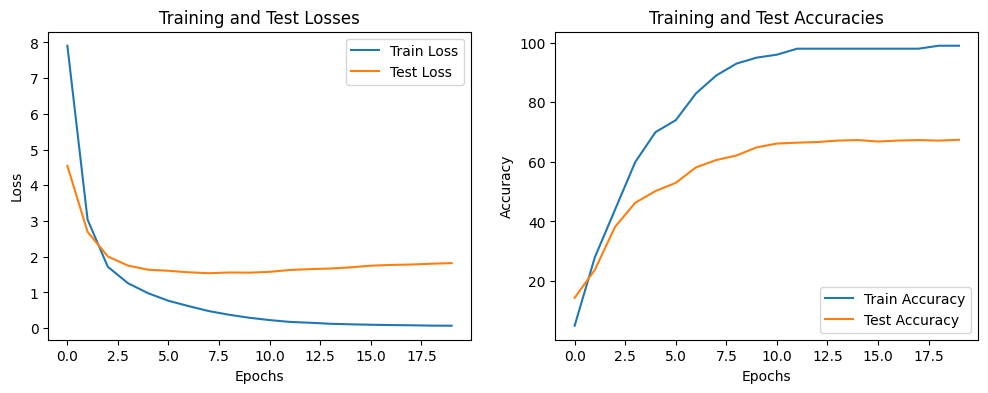

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Losses')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Test Accuracies')

plt.show()